In [10]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from utils import * 
import xarray as xr
import datetime as dt
from datetime import timedelta
from tensorflow.keras import backend as K

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers


from keras.utils.vis_utils import plot_model
from keras_visualizer import visualizer 

In [11]:
## Define paths to training and test data
cwd = os.getcwd()
train_path = "data/train/"
test_path = "data/test/"

ssrd_cutoff = 10

# Training set
train_files = ["mantua_pt","staten_pt","west_pt"]
x_train_xr, x_length  = prepare_predictor(train_files,train_path,time_reindex=False)
y_train_xr, y_length  = prepare_predictand(train_files,train_path,time_reindex=False)

#replace x_length to account for dropped values
length_mantua = sum(xr.open_dataset("data/train/inputs_mantua_pt.nc").to_dataframe().ssrd/3600 > ssrd_cutoff)
length_west = sum(xr.open_dataset("data/train/inputs_west_pt.nc").to_dataframe().ssrd/3600 > ssrd_cutoff)
length_staten = sum(xr.open_dataset("data/train/inputs_staten_pt.nc").to_dataframe().ssrd/3600 > ssrd_cutoff)
x_length = np.array([length_mantua,length_staten,length_west])
y_length = np.array(sum(xr.open_dataset("data/train/inputs_water_pt.nc").to_dataframe().ssrd/3600 > ssrd_cutoff))

# Test set
x_test_xr, _ = prepare_predictor('water_pt', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('water_pt',data_path=test_path,time_reindex=False)

#dataframes
x_train_df = x_train_xr.to_dataframe().drop(["expver"],axis=1).dropna().reset_index()
x_train_df.ssrd = x_train_df.ssrd / 3600
x_train_df = x_train_df[x_train_df.ssrd>ssrd_cutoff]  # remove ssrd < 10

x_test_df = x_test_xr.to_dataframe().drop(["expver"],axis=1).fillna(0).reset_index()
x_test_df.ssrd = x_test_df.ssrd / 3600
x_test_df = x_test_df[x_test_df.ssrd>ssrd_cutoff]  # remove ssrd < 10

y_train_df = y_train_xr.to_dataframe().dropna()
y_train_df = y_train_df.reset_index().reset_index().merge(x_train_df.reset_index().reset_index()[["index","ssrd"]], on='index', how='right') # remove corresponding ssrd < 10
y_train_df.poa = y_train_df.poa / np.cos(0.174533) #convert to GHI
y_train_df["res"] = y_train_df.poa - y_train_df.ssrd.values
y_train_df = y_train_df.set_index(["time","lat","lon"]).drop(["index","ssrd"],axis=1)

y_test_df = y_test_xr.to_dataframe().dropna()
y_test_df = y_test_df.reset_index().reset_index().merge(x_test_df.reset_index().reset_index()[["index","ssrd"]], on='index', how='right') # remove corresponding ssrd < 10
y_test_df.poa = y_test_df.poa / np.cos(0.174533) #convert to GHI
y_test_df["res"] = y_test_df.poa - y_test_df.ssrd.values
y_test_df = y_test_df.set_index(["time","lat","lon"]).drop(["index","ssrd"],axis=1)

x_train_df = x_train_df.set_index(["time"])
x_test_df = x_test_df.set_index(["time"])

In [3]:
# Standardization
x_mean, x_std = x_train_df.mean(), x_train_df.std()

x_train_df_std   = ((x_train_df - x_mean)/x_std)
x_test_df_std    = ((x_test_df - x_mean)/x_std)

y_mean, y_std = y_train_df.mean(), y_train_df.std()

y_train_df_std   = ((y_train_df - y_mean)/y_std).drop("poa",axis=1)
y_test_df_std    = ((y_test_df - y_mean)/y_std).drop("poa",axis=1)


x_train = x_train_df_std.to_numpy()
y_train = y_train_df_std.to_numpy()
x_test = x_test_df_std.to_numpy()
y_test = y_test_df_std.to_numpy()

print("Before shifting values:")
print(x_train.shape,y_train.shape)
print(x_test.shape, y_test.shape)

start = np.cumsum(x_length) - x_length
end   = np.cumsum(x_length)

slider = 24
x_train_all = []
y_train_all = []

for i in range(len(x_length)):
    
    x_subset = x_train[start[i]:end[i],:]
    y_subset = y_train[start[i]:end[i],:]
    
    x_subset = np.array([x_subset[i:i+slider] for i in range(0, x_length[i]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, x_length[i]-slider+1)])
    
    x_train_all.append(x_subset)
    y_train_all.append(y_subset)
    
x_train = np.concatenate(x_train_all,axis=0)
y_train = np.concatenate(y_train_all,axis=0)
x_test  = np.array([x_test[i:i+slider] for i in range(0, x_test.shape[0]-slider+1)])
y_test  = np.array([y_test[i:i+slider] for i in range(0, y_test.shape[0]-slider+1)])

print("\nAfter shfting time:")
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

Before shifting values:
(15152, 5) (15152, 1)
(5728, 5) (5728, 1)

After shfting time:
(15083, 24, 5) (15083, 1, 1)
(5705, 24, 5) (5705, 24, 1)


In [35]:
def QuantileLoss(perc, delta=1e-4):
    perc = np.array(perc).reshape(-1)
    perc.sort()
    perc = perc.reshape(1, -1)
    def _qloss(y, pred):
        I = tf.cast(y <= pred, tf.float32)
        d = K.abs(y - pred)
        correction = I * (1 - perc) + (1 - I) * perc
        # huber loss
        huber_loss = K.sum(correction * tf.where(d <= delta, 0.5 * d ** 2 / delta, d - 0.5 * delta), -1)
        # order loss
        q_order_loss = K.sum(K.maximum(0.0, pred[:, :-1] - pred[:, 1:] + 1e-6), -1)
        return huber_loss + q_order_loss
    return _qloss

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 24, 32)            4864      
                                                                 
 lstm_37 (LSTM)              (None, 32)                8320      
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,217
Trainable params: 13,217
Non-trainable params: 0
_________________________________________________________________

Inital test eval on different site:
Tensor("qloss/remove_squeezable_dimensions/Squeeze:0", shape=(None, 24), dtype=float32)
179/179 [==============================] - 1s 3ms/step - loss: 10.2193
Epoch 1/50
Tensor("qloss/remove_squeezable_dimensions/Squeeze:0", shape=(None, 1), dtype=float32)
Tensor("qloss/remov

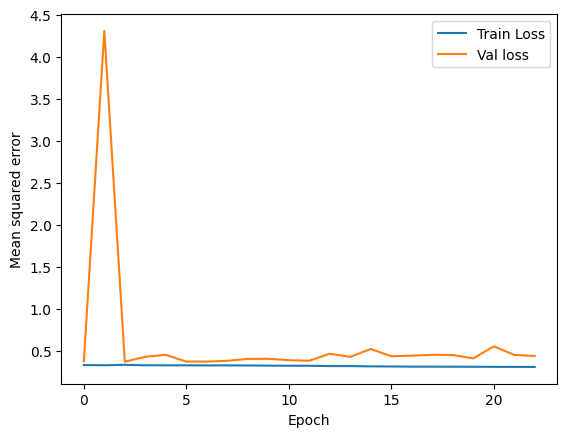

In [34]:
# set hyperparameters
n_neuron       = 32
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.01
minibatch_size = 128
model_num      = 1

perc_points = [.4]

# Build and compile the model
model = Sequential()
model.add(LSTM(n_neuron,input_shape=(x_train.shape[1],x_train.shape[2]),
               return_sequences=True,activation=activation))
model.add(LSTM(n_neuron,return_sequences=False,activation=activation))
model.add(Dense(y_train.shape[-1],activation='linear')) 
model.compile(loss=QuantileLoss(perc_points),optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model.summary()


## Train the model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

print('\nInital test eval on different site:')
model.evaluate(x_test, y_test)

history = model.fit(x_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.5,
                        callbacks=[early_stop],
                        shuffle=False)

print('\nFinal test eval on different site:')
model.evaluate(x_test, y_test)
plot_history(history)

In [52]:
# save the model
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'ssrd_res_mse_ltsm_ql_model.h5'))

#visualizer(model, format='png', view=True)


ValueError: Keras Visualizer: Layer not supported for visualizing

In [45]:
# reload the saved model
model = load_model(os.path.join(model_path,'ssrd_res_mse_ltsm_ql_model.h5'), custom_objects={"_qloss": QuantileLoss})

# predict on the test set
y_test_pre = model.predict(x_test)

# Show results with correlation matrix
df_test = x_test_df.reset_index().drop(["lat","lon"],axis=1).set_index("time")
df_test["onsite"] = y_test_df.reset_index().drop(["lat","lon"],axis=1).set_index("time").poa
df_test = df_test[slider-1:]
df_test["res"] = (y_test_pre* y_std.values[1] + y_mean.values[1])
df_test["pred"] = df_test["res"] + df_test.ssrd.values
df_test.corr()

179/179 [==============================] - 1s 3ms/step


,ssrd,tcc,t2m,onsite,res,pred
ssrd,1.000000,-0.240856,0.010491,0.876289,0.077133,0.996082
tcc,-0.240856,1.000000,0.079732,-0.286886,-0.285351,-0.263576
t2m,0.010491,0.079732,1.000000,0.002447,0.064750,0.016121
onsite,0.876289,-0.286886,0.002447,1.000000,0.141770,0.879435
res,0.077133,-0.285351,0.064750,0.141770,1.000000,0.165006
pred,0.996082,-0.263576,0.016121,0.879435,0.165006,1.000000


Text(0.5, 1.0, 'Prediction versus ERA5 and Onsite Pryanometer \n April 2021 - July 2022')

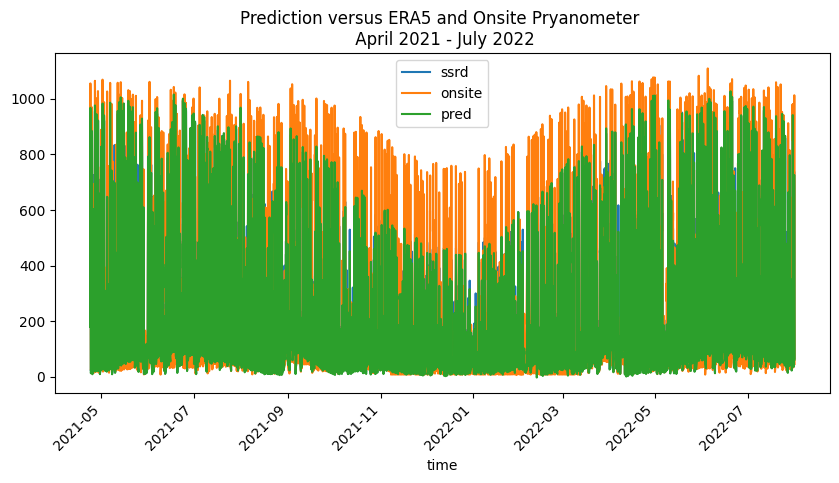

In [46]:
# Show results on total dataset
df_plot = df_test[["ssrd","onsite","pred"]]
df_plot.plot(figsize=(10,5))
plt.xticks(rotation=45)
plt.title("Prediction versus ERA5 and Onsite Pryanometer \n April 2021 - July 2022")


Text(0.5, 1.0, 'Predicted vs Actual')

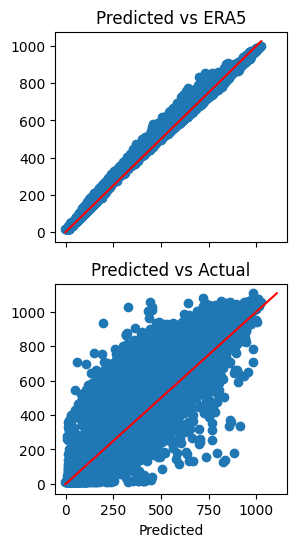

In [51]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(3,6))

# Compare against input ssrd values
ax1.scatter(df_test.pred,df_test.ssrd)
p1 = max(max(df_test.pred), max(df_test.ssrd))
p2 = min(min(df_test.pred), min(df_test.ssrd))
ax1.plot([p1, p2], [p1, p2], 'r-')
ax1.set_title("Predicted vs ERA5")

# Compare against y actual
ax2.scatter(df_test.pred,df_test.onsite)
p1 = max(max(df_test.pred), max(df_test.onsite))
p2 = min(min(df_test.pred), min(df_test.onsite))
ax2.plot([p1, p2], [p1, p2], 'r-')
ax2.set_xlabel("Predicted")
ax2.set_title("Predicted vs Actual")

(array([0, 1, 2, 3]),
 [Text(0, 0, '03-27-22'),
  Text(1, 0, '03-28-22'),
  Text(2, 0, '03-29-22'),
  Text(3, 0, '03-30-22')])

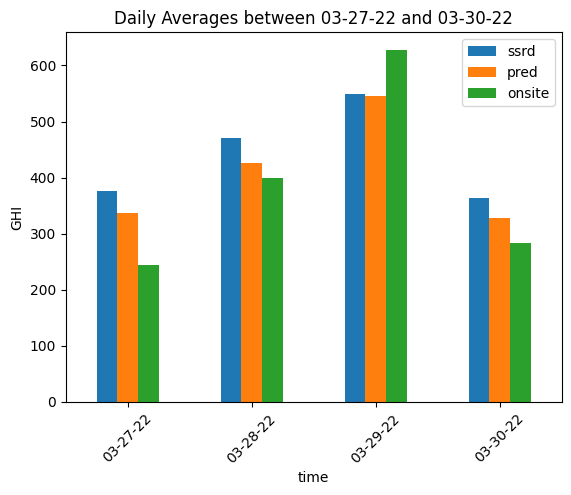

In [40]:
ind = np.arange(10)
width = 0.3       

df_bar = df_test[(df_test.index > dt.datetime(year=2022,month=3,day=27))&(df_test.index < dt.datetime(year=2022,month=3,day=31))].resample("D").mean()
df_bar.index = df_bar.index.strftime("%m-%d-%y")
df_bar[["ssrd","pred","onsite"]].plot(kind='bar')
plt.ylabel("GHI")
plt.title("Daily Averages between " + df_bar.index[0] + " and " + df_bar.index[-1])
plt.xticks(rotation=45)